In [1]:
!pip install -q numpy pandas matplotlib scikit-learn tensorflow

In [2]:
from google.colab import files
uploaded = files.upload()  # Chọn file processed_data.zip

Saving processed_data_300k.zip to processed_data_300k.zip


In [4]:
import zipfile

with zipfile.ZipFile("processed_data_300k.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

In [5]:
import pandas as pd

# Giả sử file chính là processed_data.csv trong thư mục data
df = pd.read_csv("data/processed_data_300k.csv")

print(df.head())
print("Số dòng:", len(df))


                                                   X  y
0  -1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-...  3
1  -1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-...  3
2  -1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-...  3
3  -1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-...  3
4  -1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-...  3
Số dòng: 300000


In [6]:
from sklearn.model_selection import train_test_split

# Giả sử cột 'X' là văn bản, 'y' là nhãn
texts = df['X'].astype(str)
labels = df['y']

# Chia train (70%) và temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(texts, labels, test_size=0.3, random_state=42, stratify=labels)

# Chia temp thành validation (15%) và test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)} dòng")
print(f"Validation: {len(X_val)} dòng")
print(f"Test: {len(X_test)} dòng")


Train: 210000 dòng
Validation: 45000 dòng
Test: 45000 dòng


In [7]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Mã hóa nhãn
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc = encoder.transform(y_val)
y_test_enc = encoder.transform(y_test)

# Tokenizer
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Chuẩn bị sequence và padding
maxlen = 100

def preprocess_texts(texts):
    seq = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=maxlen)

X_train_seq = preprocess_texts(X_train)
X_val_seq = preprocess_texts(X_val)
X_test_seq = preprocess_texts(X_test)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

vocab_size = 20000
embedding_dim = 128

model = Sequential([
Embedding(vocab_size, embedding_dim, input_shape=(maxlen,)),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(len(encoder.classes_), activation='softmax')  # output classes
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,700,035 (10.30 MB)

 Trainable params: 2,700,035 (10.30 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(X_train_seq, y_train_enc,
                    epochs=5,
                    batch_size=128,
                    validation_data=(X_val_seq, y_val_enc))


Epoch 1/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 697s 425ms/step - accuracy: 0.9512 - loss: 0.1517 - val_accuracy: 0.9518 - val_loss: 0.1461
Epoch 2/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 776s 446ms/step - accuracy: 0.9513 - loss: 0.1492 - val_accuracy: 0.9521 - val_loss: 0.1450
Epoch 3/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 699s 420ms/step - accuracy: 0.9509 - loss: 0.1492 - val_accuracy: 0.9518 - val_loss: 0.1441
Epoch 4/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 757s 429ms/step - accuracy: 0.9507 - loss: 0.1501 - val_accuracy: 0.9518 - val_loss: 0.1444
Epoch 5/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 742s 429ms/step - accuracy: 0.9517 - loss: 0.1482 - val_accuracy: 0.9524 - val_loss: 0.1458


In [12]:
print(X_train_seq.shape, X_train_seq.dtype)
print(y_train_enc.shape, y_train_enc.dtype)


(210000, 100) int32
(210000,) int64


In [14]:
loss, accuracy = model.evaluate(X_test_seq, y_test_enc)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 93s 66ms/step - accuracy: 0.9527 - loss: 0.1445
Test loss: 0.1493, Test accuracy: 0.9514


In [15]:
model.save("my_lstm_model.h5")


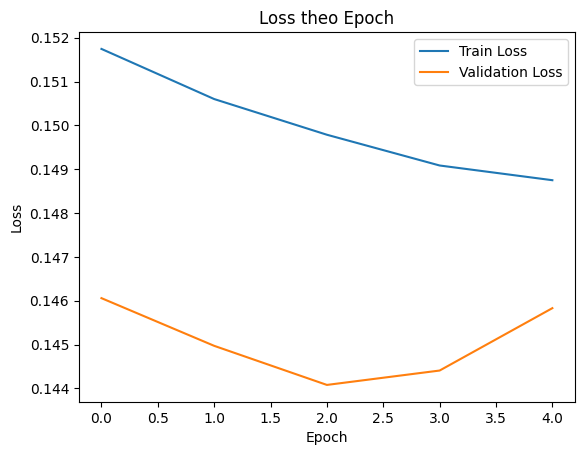

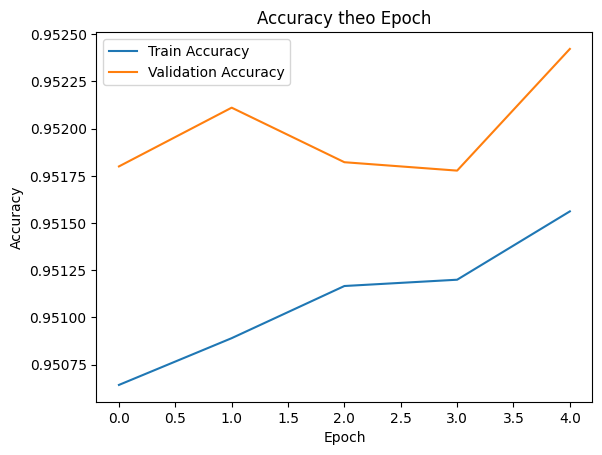

In [16]:
import matplotlib.pyplot as plt

# Vẽ Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss theo Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Vẽ Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy theo Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [17]:
from google.colab import files
files.download('my_lstm_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# Tokenize và pad dữ liệu test
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq = pad_sequences(X_test_seq, maxlen=100)  # hoặc dùng biến `maxlen` bạn đã đặt


In [19]:
y_test_enc = encoder.transform(y_test)


In [21]:
from sklearn.metrics import classification_report, f1_score

# Đổi nhãn thành chuỗi nếu là số
target_names = [str(label) for label in encoder.classes_]

# In báo cáo phân loại
print(classification_report(y_test_enc, y_pred, target_names=target_names))

# Tính F1 macro
f1 = f1_score(y_test_enc, y_pred, average='macro')
print(f"F1-score (macro): {f1:.4f}")


              precision    recall  f1-score   support

           0       0.79      0.86      0.83      2697
           3       0.97      0.98      0.97     39751
           4       0.78      0.68      0.72      2552

    accuracy                           0.95     45000
   macro avg       0.85      0.84      0.84     45000
weighted avg       0.95      0.95      0.95     45000

F1-score (macro): 0.8407


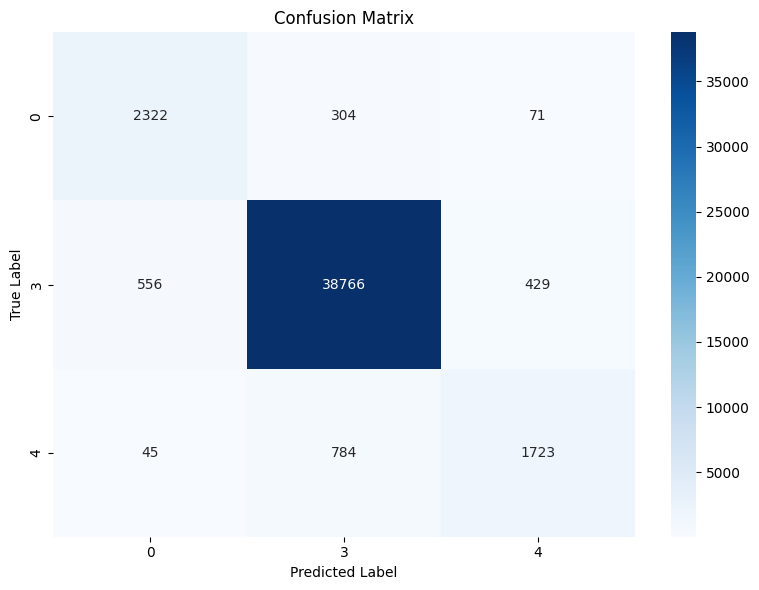

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Ma trận nhầm lẫn
cm = confusion_matrix(y_test_enc, y_pred)
labels = encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Hàm tiền xử lý cho text: tokenize + padding
def preprocess_texts(texts):
    seq = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=maxlen)

# Giả sử X_test là list các câu test thô
X_test_seq = preprocess_texts(X_test)  # Tokenize + padding
print(type(X_test_seq), X_test_seq.shape)  # Kiểm tra xem đúng chưa

# Lấy mẫu test đầu tiên, reshape thành batch 1
sample = X_test_seq[0].reshape(1, -1)
print("Shape mẫu test:", sample.shape)  # (1, maxlen)

# Dự đoán
pred = model.predict(sample)
print("Output dự đoán (xác suất softmax):", pred)

# Lấy nhãn dự đoán
pred_label_index = np.argmax(pred, axis=1)[0]
pred_label = encoder.inverse_transform([pred_label_index])
print("Nhãn dự đoán:", pred_label[0])




<class 'numpy.ndarray'> (45000, 100)
Shape mẫu test: (1, 100)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Output dự đoán (xác suất softmax): [[8.1996805e-05 9.9762851e-01 2.2896249e-03]]
Nhãn dự đoán: 3
